# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

### KEY TASKS

- Want na flags in classification but not in clustering
- Run clustering with bigger samples
- Why is grp 7 missing?
- See if clusters have any predictive value
- Better imputation on key vars
- Refactor code
- Git upload

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sklearn
import random

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data

#p1=0.2
#p2=0.2
         
%time azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';', parse_dates = ['EINGEFUEGT_AM'])#, skiprows=lambda i: i>0 and random.random() > 1-p1)
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';', parse_dates = ['EINGEFUEGT_AM'])#, skiprows=lambda i: i>0 and random.random() > 1-p2)

<string>:2: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 34.1 s, sys: 26.2 s, total: 1min
Wall time: 4min 25s


/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(azdias.shape)
print(customers.shape)

azdias = azdias.sample(frac=0.5, random_state=0) 
customers = customers.sample(frac=1, random_state=0) 

(891221, 366)
(191652, 369)


In [4]:
# Adjust viewing options to allow EDA

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)

In [5]:
# Check memory requirements

azdias.info()
#891221 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 445610 entries, 517045 to 308826
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(267), int64(93), object(5)
memory usage: 1.2+ GB


In [6]:
# Check memory requirements

customers.info()
#191652 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 191652 entries, 177959 to 43567
Columns: 369 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(267), int64(94), object(7)
memory usage: 541.0+ MB


In [7]:
print(azdias.shape)
azdias.head()

(445610, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [8]:
# Examine differences in columns

set(azdias.columns) - set(customers.columns)

set()

In [111]:
azdias.head(10).describe().T.head(20)

,count,mean,std,min,25%,50%,75%,max
LNR,10.0,430302.700000,182163.941741,218434.0,288227.75,407167.0,548512.00,795862.0
AGER_TYP,10.0,0.500000,1.649916,-1.0,-1.00,0.0,2.00,3.0
AKT_DAT_KL,10.0,5.000000,4.216370,1.0,1.00,5.0,9.00,9.0
ALTER_HH,10.0,8.600000,7.183314,0.0,1.75,9.0,12.25,20.0
ALTER_KIND1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALTER_KIND2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALTER_KIND3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALTER_KIND4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALTERSKATEGORIE_FEIN,6.0,11.166667,4.792355,7.0,8.25,9.5,12.25,20.0
ANZ_HAUSHALTE_AKTIV,10.0,11.600000,15.714113,1.0,1.00,4.5,16.50,49.0


In [10]:
print(customers.shape)
customers.head()

(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [112]:
customers.head(10).describe().T.head(20)

,count,mean,std,min,25%,50%,75%,max
LNR,10.0,110385.400000,60704.936452,2449.0,71770.75,125249.5,150463.75,189767.0
AGER_TYP,10.0,0.300000,1.418136,-1.0,-1.00,0.0,1.75,2.0
AKT_DAT_KL,7.0,3.142857,3.670993,1.0,1.00,1.0,4.50,9.0
ALTER_HH,7.0,10.714286,5.250850,0.0,10.00,11.0,14.50,15.0
ALTER_KIND1,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALTER_KIND2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALTER_KIND3,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALTER_KIND4,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALTERSKATEGORIE_FEIN,7.0,11.142857,2.478479,9.0,9.00,11.0,12.50,15.0
ANZ_HAUSHALTE_AKTIV,7.0,3.571429,3.154739,1.0,1.00,2.0,5.50,9.0


In [12]:
# List of non-customer fields - drops PRODUCT_GROUP and CUSTOMER_GROUP
keep_cols = list(azdias.columns)

### Data dictionaries

In [13]:
xls = pd.ExcelFile("DIAS Attributes - Values 2017.xlsx")
values_dict = pd.read_excel(xls, 'Tabelle1')
values_dict.iloc[:,1:].head(5)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


In [14]:
xls = pd.ExcelFile("DIAS Information Levels - Attributes 2017.xlsx")
values_dict = pd.read_excel(xls, 'Komplett')
values_dict.iloc[:,1:].head(5)

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


### Explore non-numerical vars

In [15]:
# Small number of variables need pre-processing so use specific porcessing rather than generic gap filling

list(azdias.dtypes[azdias.dtypes =='object'].index)

['CAMEO_DEU_2015',
 'CAMEO_DEUG_2015',
 'CAMEO_INTL_2015',
 'D19_LETZTER_KAUF_BRANCHE',
 'OST_WEST_KZ']

### Check missingness

In [16]:
# For visualisation of missingness

#!pip install missingno
#import missingno as msno
#msno.matrix(customers)

In [17]:
# Add groups of data feeds which are missing collectively

grp1 = ['KBA05_SEG7', 'KBA05_KW1', 'KBA05_SEG4','KBA05_SEG5','KBA05_SEG6','KBA05_MAXAH',
         'KBA05_SEG8', 'KBA05_KW2', 'KBA05_VORB0', 'KBA05_KRSZUL', 'KBA05_VORB1', 'KBA05_KRSVAN',
         'KBA05_KRSOBER', 'KBA05_SEG9', 'MOBI_REGIO', 'KBA05_KW3', 'KBA05_SEG3', 'KBA05_KRSHERST3',
         'KBA05_MAXBJ', 'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1', 'KBA05_MOD2',
         'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG2',
         'KBA05_KRSKLEIN', 'KBA05_KRSAQUOT', 'KBA05_KRSHERST2', 'KBA05_KRSHERST1', 'KBA05_ZUL4', 'KBA05_ALTER1',
         'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ZUL3', 'KBA05_ALTER4', 'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ZUL2',
         'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1', 'KBA05_CCM2',
         'KBA05_CCM3', 'KBA05_ZUL1', 'KBA05_CCM4', 'KBA05_VORB2', 'KBA05_DIESEL', 'KBA05_FRAU', 'KBA05_GBZ',
         'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3', 'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_SEG10', 'KBA05_SEG1']

grp2 = ['PLZ8_ANTG1', 'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_BAUMAX', 'PLZ8_GBZ', 'PLZ8_HHZ']

grp3 = ['KBA13_CCM_3000', 'KBA13_FORD', 'KBA13_FIAT', 'KBA13_FAB_SONSTIGE', 'KBA13_CCM_3001',
        'KBA13_HERST_ASIEN','KBA13_CCM_2501', 'KBA13_CCM_2500', 'KBA13_CCM_2000', 'KBA13_CCM_1800',
        'KBA13_HALTER_20', 'KBA13_GBZ', 'KBA13_HALTER_55', 'KBA13_HALTER_25', 'KBA13_HALTER_30',
        'KBA13_HALTER_35', 'KBA13_HALTER_40', 'KBA13_HALTER_45', 'KBA13_HALTER_50', 'KBA13_CCM_1500',
        'KBA13_HALTER_60', 'KBA13_HALTER_65', 'KBA13_HALTER_66', 'KBA13_CCM_1600', 'KBA13_ALTERHALTER_30',
        'KBA13_CCM_1401_2500', 'KBA13_AUTOQUOTE', 'KBA13_HERST_BMW_BENZ', 'KBA13_ALTERHALTER_45', 'KBA13_ALTERHALTER_60',
        'KBA13_ALTERHALTER_61', 'KBA13_ANTG1', 'KBA13_ANTG2', 'KBA13_ANTG3', 'KBA13_ANTG4', 'KBA13_ANZAHL_PKW',
        'KBA13_AUDI', 'KBA13_BAUMAX', 'KBA13_CCM_1400', 'KBA13_BJ_1999', 'KBA13_BJ_2000',
        'KBA13_BJ_2004', 'KBA13_BJ_2006', 'KBA13_BJ_2008', 'KBA13_BJ_2009', 'KBA13_BMW',
        'KBA13_CCM_0_1400', 'KBA13_CCM_1000', 'KBA13_CCM_1200', 'KBA13_HERST_AUDI_VW', 'KBA13_FAB_ASIEN',
        'KBA13_HERST_EUROPA', 'KBA13_SEG_OBERKLASSE', 'KBA13_MOTOR', 'KBA13_NISSAN', 'KBA13_OPEL',
        'KBA13_PEUGEOT', 'KBA13_RENAULT', 'KBA13_SEG_GELAENDEWAGEN', 'KBA13_SEG_GROSSRAUMVANS', 'KBA13_SEG_KLEINST',
        'KBA13_SEG_KLEINWAGEN', 'KBA13_SEG_KOMPAKTKLASSE', 'KBA13_SEG_MINIVANS', 'KBA13_SEG_MINIWAGEN', 'KBA13_SEG_MITTELKLASSE',
        'KBA13_SEG_OBEREMITTELKLASSE', 'KBA13_SEG_SPORTWAGEN', 'KBA13_MAZDA', 'KBA13_SEG_UTILITIES', 'KBA13_SEG_VAN',
        'KBA13_SEG_WOHNMOBILE', 'KBA13_SITZE_4', 'KBA13_SITZE_5', 'KBA13_SITZE_6', 'KBA13_TOYOTA',
        'KBA13_VORB_0', 'KBA13_VORB_1', 'KBA13_VORB_1_2', 'KBA13_VORB_2', 'KBA13_VORB_3',
        'KBA13_VW', 'KBA13_HERST_FORD_OPEL', 'KBA13_MERCEDES', 'KBA13_SEG_SONSTIGE', 'KBA13_KW_90',
        'KBA13_HHZ', 'KBA13_KMH_110', 'KBA13_KMH_140', 'KBA13_KMH_140_210', 'KBA13_KMH_180',
        'KBA13_KMH_210', 'KBA13_KMH_211', 'KBA13_KMH_250', 'KBA13_KMH_251', 'KBA13_KRSAQUOT',
        'KBA13_KRSHERST_AUDI_VW', 'KBA13_KRSHERST_BMW_BENZ', 'KBA13_KRSHERST_FORD_OPEL', 'KBA13_HERST_SONST',
        'KBA13_KRSSEG_KLEIN', 'KBA13_KW_80', 'KBA13_KRSSEG_OBER', 'KBA13_KRSSEG_VAN', 'KBA13_KRSZUL_NEU',
        'KBA13_KW_0_60', 'KBA13_KW_110', 'KBA13_KW_120', 'KBA13_KW_121', 'KBA13_KW_30',
        'KBA13_KW_40', 'KBA13_KW_50', 'KBA13_KW_60', 'KBA13_KW_61_120', 'KBA13_KW_70', 'KBA13_KMH_0_140']

grp4 = ['CAMEO_INTL_2015','CAMEO_DEUG_2015']

grp5 = ['UMFELD_JUNG', 'UMFELD_ALT']

grp6 = ['VERDICHTUNGSRAUM','STRUKTURTYP','GEMEINDETYP','ARBEIT','RELAT_AB','ORTSGR_KLS9']

#FIX THIS
grp7 = ['ANZ_STATISTISCHE_HAUSHALTE', 'EINGEFUEGT_MONTH', 'EINGEFUEGT_YEAR', 'WOHNLAGE','DSL_FLAG',
        'GEBAEUDETYP', 'EINGEFUEGT_DAY', 'KBA05_MODTEMP', 'ANZ_HAUSHALTE_AKTIV', 'MOBI_RASTER',
        'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_HERSTTEMP']

grp8 = ['ANZ_TITEL','VHA','AKT_DAT_KL','ALTER_HH','WOHNDAUER_2008',
        'EINGEZOGENAM_HH_JAHR', 'ANZ_PERSONEN', 'ANZ_KINDER', 'UNGLEICHENN_FLAG',
        'SOHO_KZ', 'TITEL_KZ']

grp9 = ['LP_STATUS_FEIN', 'LP_LEBENSPHASE_GROB', 'ONLINE_AFFINITAET', 'LP_FAMILIE_FEIN', 'CJT_GESAMTTYP',
        'LP_FAMILIE_GROB','LP_STATUS_GROB', 'LP_LEBENSPHASE_FEIN', 'CJT_TYP_5', 'RT_KEIN_ANREIZ',
        'CJT_TYP_3', 'GFK_URLAUBERTYP', 'RT_SCHNAEPPCHEN', 'CJT_TYP_2', 'CJT_TYP_1', 'CJT_TYP_4',
        'RETOURTYP_BK_S', 'CJT_KATALOGNUTZER', 'CJT_TYP_6']

In [18]:
# Rank order missingngess

#customers.isnull().sum().sort_values(ascending=False)/len(customers)
#azdias.isnull().sum().sort_values(ascending=False)/len(azdias)

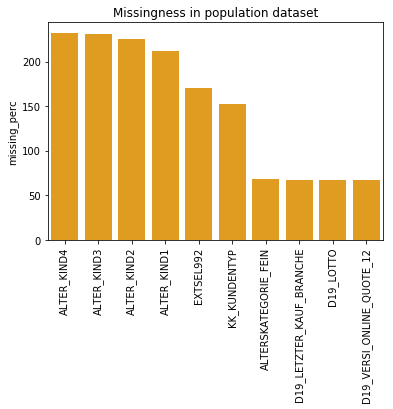

In [19]:
cust_gaps = pd.DataFrame(100*azdias.isnull().sum().sort_values(ascending=False)/len(customers))
cust_gaps.columns = ['missing_perc']
ax = sns.barplot(data=cust_gaps.head(10), x=cust_gaps.head(10).index, y='missing_perc', color='orange')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Missingness in population dataset')
plt.show()

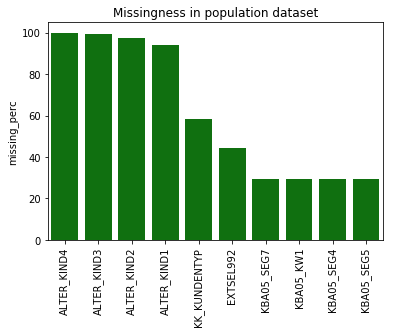

In [20]:
cust_gaps = pd.DataFrame(100*customers.isnull().sum().sort_values(ascending=False)/len(customers))
cust_gaps.columns = ['missing_perc']
ax = sns.barplot(data=cust_gaps.head(10), x=cust_gaps.head(10).index, y='missing_perc', color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Missingness in population dataset')
plt.show()

### Data processing I

In [21]:
def clean_nas(df):
    '''
    Drop nas in groups of columns, retain only first entry
    Also adds random column to assist downstream feature rationalisation
    '''
    i=1
    for grp in [grp1, grp2, grp3, grp4, grp5, grp6, grp7, grp8, grp9]:
        cols = [s + '_na' for s in grp[1:]]    
        try:
            df.drop(cols, axis=1, inplace=True)  
            print(str(i) + " processed")
        except:
            pass
        i=i+1
        
    df['randNumCol'] = np.random.randint(1, 10, df.shape[0])
    
    return df

In [22]:
def process_dates(df):
    df['EINGEFUEGT_YEAR'] = df['EINGEFUEGT_AM'].dt.year
    df['EINGEFUEGT_MONTH'] = df['EINGEFUEGT_AM'].dt.month
    df['EINGEFUEGT_DAY'] = df['EINGEFUEGT_AM'].dt.day
    df.drop(['EINGEFUEGT_AM'], axis=1, inplace=True)
    return df

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [23]:
!pip install sklearn-pandas

In [24]:
# Import libraries

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_pandas import DataFrameMapper

In [25]:
map2 = pd.DataFrame(azdias['CAMEO_DEU_2015'].value_counts())
map2['mapped_value'] = np.arange(len(map2))

In [26]:
map1 = pd.DataFrame(azdias['D19_LETZTER_KAUF_BRANCHE'].value_counts())
map1['mapped_value'] = np.arange(len(map1))

In [27]:
#Write function to make clean dataset df_X from X

from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype

def preprocess_df(df1):
    '''
    Clean up mixed datatype columns
    Fix categorical data
    Drop columns 
    
    '''
    # Clean feeds
    df1['CAMEO_DEUG_2015'] = df1['CAMEO_DEUG_2015'].apply(lambda x: 0 if x=='X' else float(x))
    df1['CAMEO_INTL_2015'] = df1['CAMEO_INTL_2015'].apply(lambda x: 0 if x=='XX' else float(x))
    
    # Mapping via manual dictionaries, should drop one for
    pd.get_dummies(azdias['CAMEO_DEU_2015'], prefix='CAMEO_DEU_2015')
    pd.get_dummies(azdias['D19_LETZTER_KAUF_BRANCHE'], prefix='D19_LETZTER_KAUF_BRANCHE')
    
    # Binary flag 
    df1['OST_WEST_KZ'] = df1['OST_WEST_KZ'].apply(lambda x: 0 if x=='W' else 1 if x=='O' else -1)
    
#    df2 = df1.drop(['CAMEO_DEU_2015','CAMEO_DEUG_2015','CAMEO_INTL_2015','D19_LETZTER_KAUF_BRANCHE','OST_WEST_KZ'],axis=1)
    df2 = df1.drop(['CAMEO_DEU_2015','D19_LETZTER_KAUF_BRANCHE'],axis=1)
    df2 = df2.apply(lambda x: x.fillna(x.mean()),axis=0)
    df1 = None

    return df2

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.
    Parameters:
    -----------
    df: The data frame that will be changed.
    col: The column of data to fix by filling in missing data.
    name: The name of the new filled column in df.
    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

In [28]:
#LEGACY CODE - DELETE
# Filter for common, populated columns

#azdias = azdias[keep_cols]
customers = customers[keep_cols]

In [29]:
# Process dates to remove datetime field and add year, month, day attributes

azdias = process_dates(azdias)
customers = process_dates(customers)

In [30]:
#train_cats(azdias)
#apply_cats(df=customers, trn=azdias)

In [31]:
# Other option for sampling

#azdias['dummy_col'] = 1
#azdias_sample = azdias.sample(frac=0.1)
#%time df_azdias, y, na_train, scale_train = proc_df(azdias, 'dummy_col', do_scale=True, max_n_cat=7)

In [32]:
%time df_azdias = preprocess_df(azdias)
%time df_customers = preprocess_df(customers)

CPU times: user 5.69 s, sys: 12 s, total: 17.7 s
Wall time: 2min 37s
CPU times: user 2.93 s, sys: 4.11 s, total: 7.05 s
Wall time: 56 s


In [33]:
#%time df_customers,_,nas, scale_customers = proc_df(customers, na_dict=na_train, do_scale=True, max_n_cat=7, mapper=scale_train)

In [34]:
# Condense nas - REMOVE??

# clean_nas(df_azdias)
# clean_nas(df_customers)

In [35]:
print(df_azdias.shape)
df_azdias.head()

(445610, 366)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA

In [36]:
# Scale all columns for mean of 0, std of 1
# Fit model on train data so can be applied to customer and test datasets
# Application removed as added to pre-processing proc_df function

scaler = StandardScaler()

%time train_X = pd.DataFrame(scaler.fit_transform(df_azdias), columns=df_azdias.columns)
%time test_X = pd.DataFrame(scaler.transform(df_customers), columns=df_customers.columns)

#%time train_X = scaler.fit_transform(df_azdias)
#%time test_X = scaler.transform(df_customers)

# If using proc_df scaling
#train_X = df_azdias
#test_X = df_customers

CPU times: user 4.61 s, sys: 17 s, total: 21.7 s
Wall time: 2min
CPU times: user 921 ms, sys: 1.61 s, total: 2.53 s
Wall time: 9.69 s


In [37]:
train_X.shape

(445610, 366)

In [38]:
# Write processed files to workspace and read

#df_azdias.to_csv("df_azdias.csv", index=False)
#df_customers.to_csv("df_customers.csv", index=False)

In [39]:
# Read files from workspace

#%time df_customers = pd.read_csv('df_customers.csv')

### PCA

In [40]:
pca_cols = df_azdias.columns

In [41]:
# Alternative process for normalisation

#df_norm = preprocessing.normalize(df_azdias)
#standardized_X = preprocessing.scale(X)

In [42]:
# pca_results.tail(5)

In [43]:
# Fit PCA with X components 

N_COMPONENTS=100  #44 
pca = PCA(n_components=N_COMPONENTS)
pca.fit(train_X)
train_X_pca = pca.transform(train_X)
train_X_pca = pd.DataFrame(pca.transform(train_X))
#print(pca.explained_variance_ratio_)
print(sum(pca.explained_variance_ratio_))

0.762597742337


## PCA findings

- Choosing to use 44 dimensions to retain 60% of variance after rescaling 

In [44]:
def display_component(v, features_list, component_num, n_weights=10):
    '''
    Function to display attributes associated with principcal components
    
       Parameters:
    -----------
    v: pca matrix
    features_list:  column headings in input 
    component_num: 
    n_weights: number of most important variables shown
    '''    
    
    row_idx = N_COMPONENTS-component_num
    v_1_row = v.iloc[:, row_idx]
    v_1 = np.squeeze(v_1_row.values)
    comps = pd.DataFrame(list(zip(v_1, features_list)), 
                         columns=['weights', 'features'])
    comps['abs_weights']=comps['weights'].apply(lambda x: np.abs(x))
    sorted_weight_data = comps.sort_values('abs_weights', ascending=False).head(n_weights)

    # Plot charts
    ax=plt.subplots(figsize=(10,6))
    ax=sns.barplot(data=sorted_weight_data, 
                   x="weights", 
                   y="features", 
                   palette="Blues_d")
    ax.set_title("PCA Component Makeup, Component #" + str(component_num))
    plt.show()

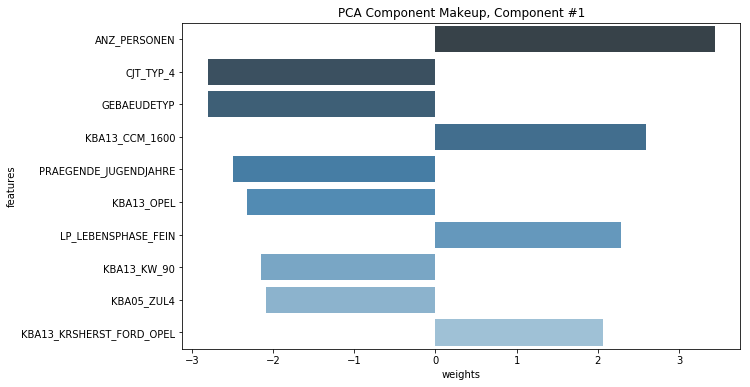

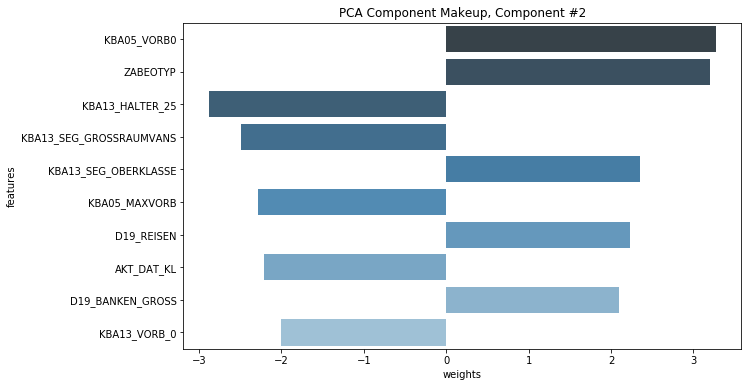

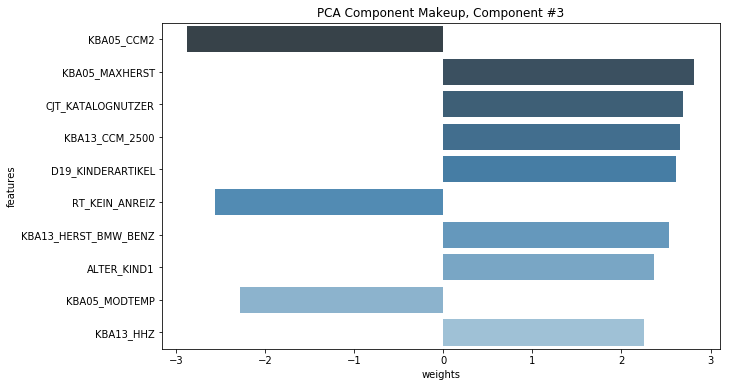

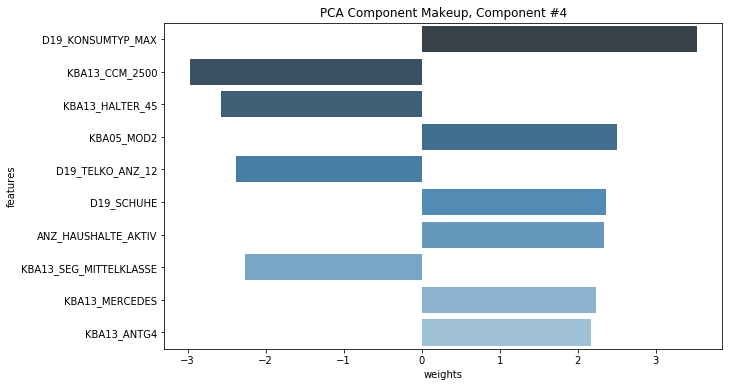

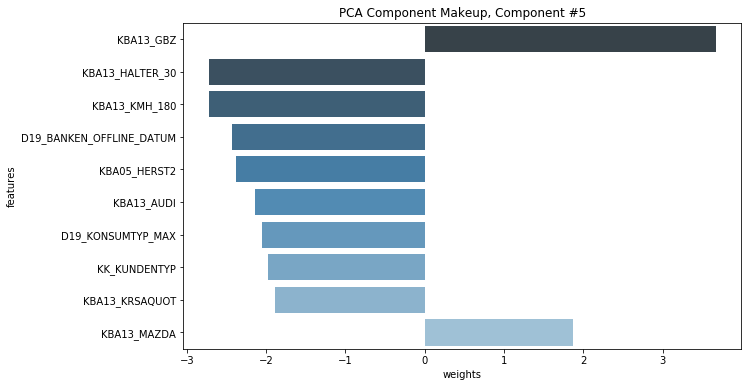

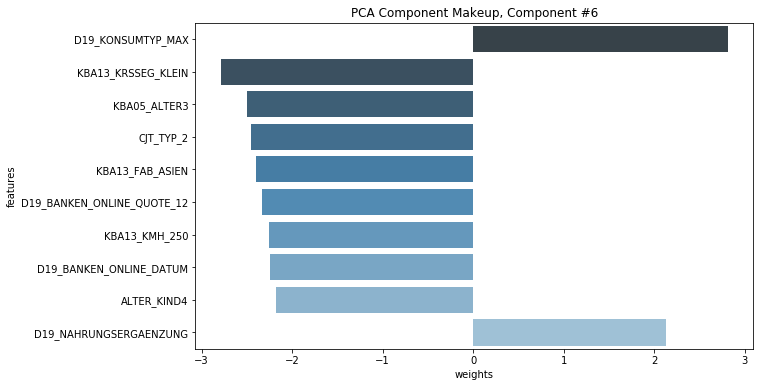

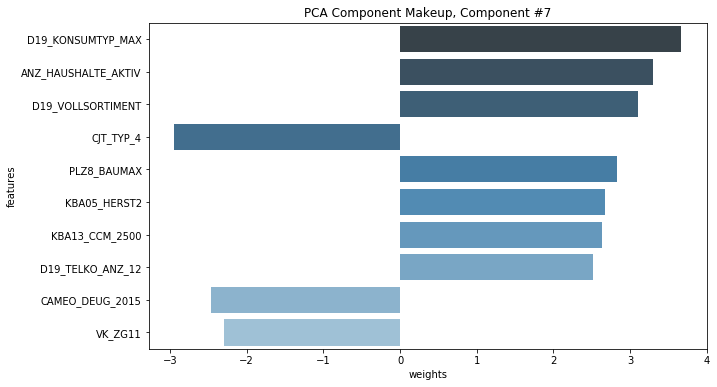

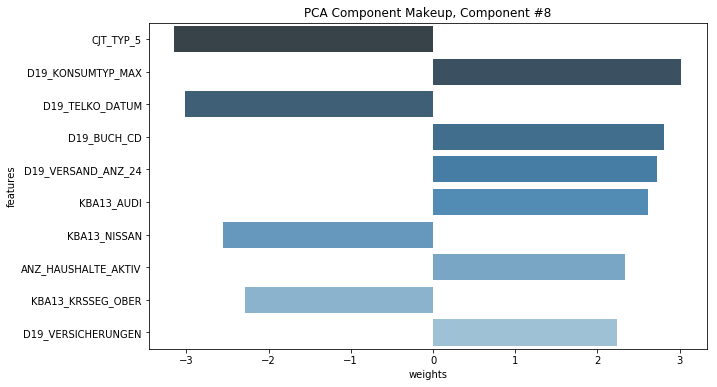

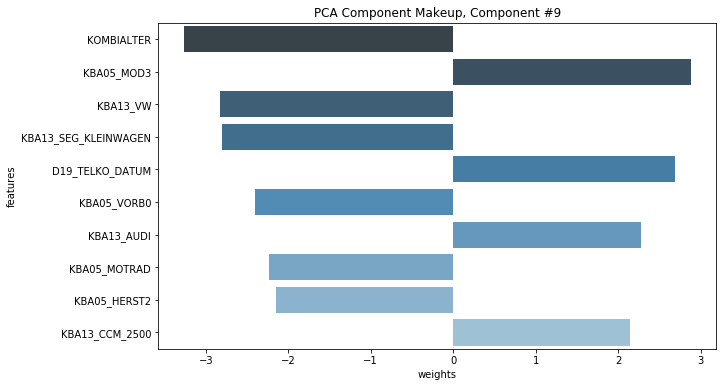

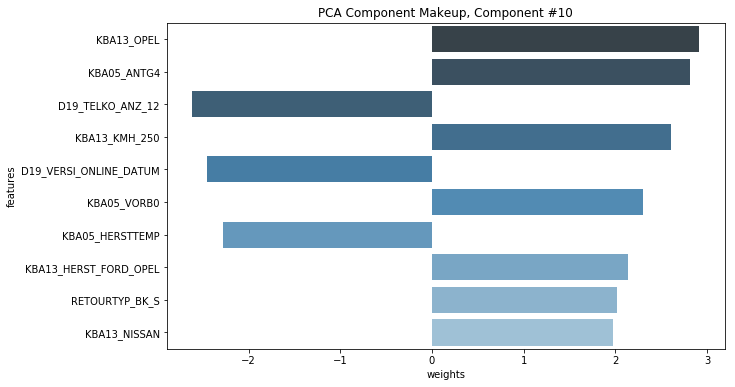

In [45]:
for num in range(1,11):
    display_component(train_X_pca, df_azdias.columns.values, component_num=num, n_weights=10)

In [46]:
# Figure out CJT - customer type

Commentary on clusters:
- PCA 1: Low share of low power cars, high share of powerful cars, blank household income, low share of old cars,
- PCA 2: 
- PCA 3: money savers, low financial prep, traditional mindset, older individuals

### Clustering

Use elbow method to explore optimal number of clusters

- Visually select 10 clusters to identfy approximate elbow

In [47]:
kmeans = KMeans(n_clusters=10, init='k-means++', max_iter=50, n_init=10, random_state=0)

# Using PCA space
%time pred_y = kmeans.fit_predict(train_X_pca)

# Using full space
# %time pred_y = kmeans.fit_predict(train_X)

df_clusters = pd.DataFrame(pred_y, columns = ['clusters'])

CPU times: user 1min 55s, sys: 3.95 s, total: 1min 59s
Wall time: 2min 2s


In [48]:
# Add clustering based on PCA space
test_X_pca = pd.DataFrame(pca.transform(test_X))
pred_y = kmeans.predict(test_X_pca)

# Run pca based on  
# pred_y = kmeans.predict(test_X)

df_clusters_customers = pd.DataFrame(pred_y, columns = ['clusters'])

In [49]:
clusters_summary = pd.DataFrame(df_clusters['clusters'].value_counts())#/len(df_clusters['clusters']))
clusters_summary.columns = ['pop_clusters']

In [50]:
clusters_cust_summary = pd.DataFrame(df_clusters_customers['clusters'].value_counts())#/len(df_clusters_customers['clusters']))
clusters_cust_summary.columns = ['customer_clusters']

In [51]:
clusters_summary = clusters_summary.merge(clusters_cust_summary, left_index=True, right_index=True)
clusters_summary['customer_ratio'] = clusters_summary['customer_clusters'] / clusters_summary['pop_clusters']

In [52]:
clusters_summary.sort_values(by='customer_ratio', ascending=False, inplace=True)
clusters_summary

,pop_clusters,customer_clusters,customer_ratio
0,43599,46915,1.076057
2,36822,28661,0.778366
4,63612,43519,0.684132
5,71495,47395,0.662913
9,47760,9780,0.204774
7,26804,3887,0.145016
1,35121,4685,0.133396
6,7370,933,0.126594
3,47493,4309,0.090729
8,65534,1568,0.023927


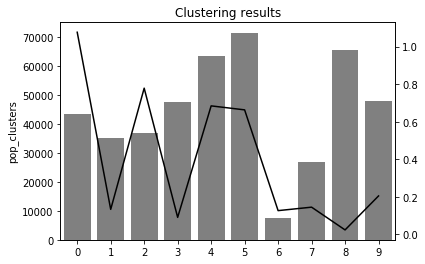

In [53]:
t = clusters_summary.sort_index()
ax = sns.barplot(x=t.index, y=t.pop_clusters, color='grey')
ax2 = ax.twinx()
ax2 = plt.plot(t.customer_ratio, color='black')
plt.title("Clustering results")
plt.show()

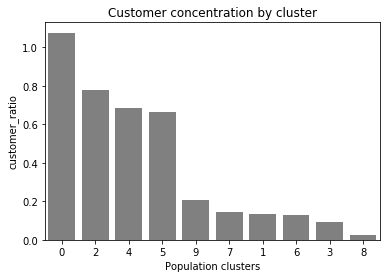

In [54]:
ax = sns.barplot(x=clusters_summary.index, y=clusters_summary.customer_ratio, 
                 order=clusters_summary.index, color='grey')
ax.set(xlabel='Population clusters')
plt.title("Customer concentration by cluster")
plt.show()

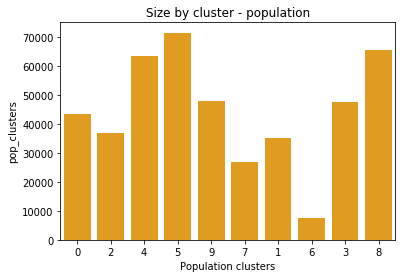

In [55]:
ax = sns.barplot(x=clusters_summary.index, y=clusters_summary.pop_clusters, order=clusters_summary.index, color='orange')
ax.set(xlabel='Population clusters')
plt.title("Size by cluster - population")
plt.show()

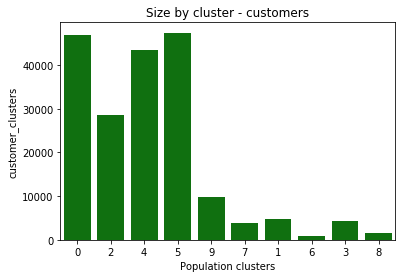

In [56]:
ax = sns.barplot(x=clusters_summary.index, y=clusters_summary.customer_clusters, order=clusters_summary.index, color='green')
ax.set(xlabel='Population clusters')
plt.title("Size by cluster - customers")
plt.show()

### Clean up

In [57]:
# Clean up memory if required

#azdias = customers = None

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [58]:
mailout_train = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';', parse_dates = ['EINGEFUEGT_AM'])

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [59]:
mailout_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42962 entries, 0 to 42961
Columns: 367 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(267), int64(94), object(5)
memory usage: 120.3+ MB


In [60]:
# Check balance of training set

mailout_train['RESPONSE'].mean()

0.012383036171500396

### Data processing II

In [61]:
# Process date column

mailout_train = process_dates(mailout_train)
mailout_train.shape

(42962, 369)

In [62]:
# Make copy for two separate processing pipelines for PCA vs classification

df = mailout_train.copy()

In [63]:
## CLASSIFICATION PIPELINE

# Add na flags
na_dict = {}
for n,c in df.items(): 
    na_dict = fix_missing(df, c, n, na_dict)
    
%time df = preprocess_df(df)
y = df['RESPONSE'].values
df.drop(['RESPONSE'], axis=1, inplace=True)

# Clean na flags and adds random column
%time df = clean_nas(df)

#%time df = pd.DataFrame(scaler.transform(df), columns=df.columns)


CPU times: user 1.75 s, sys: 610 ms, total: 2.36 s
Wall time: 9.43 s
1 processed
2 processed
3 processed
5 processed
6 processed
8 processed
9 processed
CPU times: user 240 ms, sys: 0 ns, total: 240 ms
Wall time: 261 ms


In [64]:
df.shape

(42962, 419)

In [65]:
## PCA PIPELINE

df_pca = preprocess_df(mailout_train)
df_pca.drop(['RESPONSE'], axis=1, inplace=True)

# Prep PCA dataset
%time test_X = pd.DataFrame(scaler.transform(df_pca), columns=df_pca.columns)

# Add clustering info

# Using original space
# test_clusters = kmeans.predict(df[pca_cols])

# Using pca space
%time test_X = pd.DataFrame(scaler.transform(df_pca), columns=df_pca.columns)

test_X_pca = pd.DataFrame(pca.transform(test_X))
#test_clusters = kmeans.predict(test_X_pca)

test_clusters = kmeans.predict(test_X_pca)

CPU times: user 107 ms, sys: 42.5 ms, total: 150 ms
Wall time: 167 ms
CPU times: user 131 ms, sys: 0 ns, total: 131 ms
Wall time: 131 ms


In [66]:
mailout_train['cluster'] = test_clusters
results = mailout_train[['cluster','RESPONSE']].groupby(['cluster']).agg(['count', 'mean'])
results.columns = ['response_count', 'response_mean']

# Add cluster predictions to df for input to main modelling
df['cluster'] = test_clusters

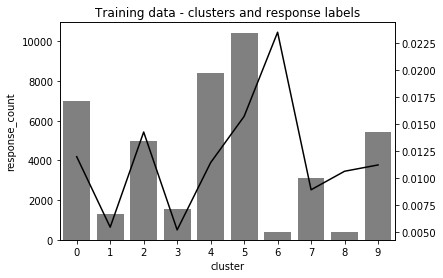

In [67]:
# Visualise reponse rate and population by cluster

ax = sns.barplot(x=results.index, y=results.response_count, color='grey')
ax2 = ax.twinx()
ax2 = plt.plot(results.response_mean, color='black')
plt.title("Training data - clusters and response labels")
plt.show()

### Modelling

In [68]:
!pip install graphviz

In [69]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import roc_auc_score
import sklearn.model_selection as ms
from sklearn.tree import DecisionTreeClassifier
#from sklearn import tree
from sklearn.tree import export_graphviz
import IPython
import graphviz
import re
from sklearn.metrics import confusion_matrix

%matplotlib inline

In [70]:
## Functons for model analysis and visuals

def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
           roc_auc_score(y_train, m.predict_proba(X_train)[:,1]), roc_auc_score(y_valid, m.predict_proba(X_valid)[:,1])]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)
    
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.
    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))
    
def tree_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False) 

def line_coef(m,df):
    return pd.DataFrame({'cols':df.columns, 'coef':m.coef_[0]}
                       ).sort_values('coef', ascending=False)

In [71]:
X_train, X_valid, y_train, y_valid = train_test_split(df, y, test_size=0.4)

# Make combined dataset for final training
X_comb = pd.concat([X_train, X_valid], axis=0)
y_comb = np.concatenate((y_train, y_valid))
X_comb.shape

(42962, 420)

## Baseline model - decision tree

In [72]:
dec_tree = DecisionTreeClassifier(min_samples_leaf=1000, class_weight = 'balanced') #class_weight = 'balanced'
%time dec_tree.fit(X_train, y_train)
print_score(dec_tree)

CPU times: user 1.56 s, sys: 103 ms, total: 1.67 s
Wall time: 1.68 s
[0.5436311056834494, 0.5489694632966732, 0.81172828371825212, 0.75716410188508998]


In [73]:
# Examine confusion matrix

confusion_matrix(y_valid, dec_tree.predict(X_valid))

array([[11864,  5129],
       [   50,   142]])

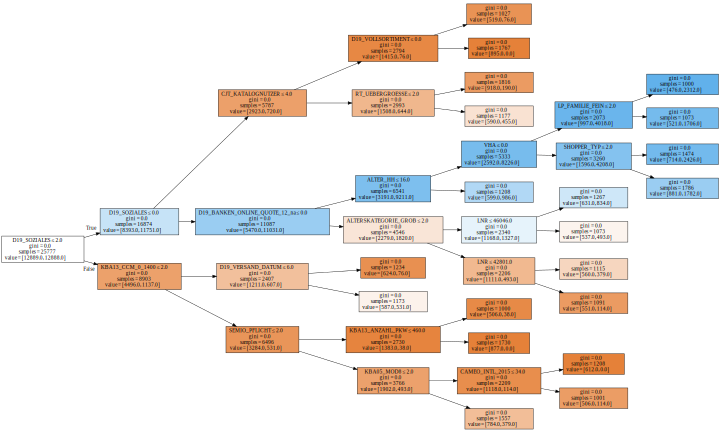

In [74]:
draw_tree(dec_tree, X_train)

In [75]:
fi = tree_feat_importance(dec_tree, X_train).head(10)
fi

,cols,imp
67,D19_SOZIALES,0.654249
376,D19_BANKEN_ONLINE_QUOTE_12_na,0.138174
80,D19_VERSAND_DATUM,0.029042
20,CJT_KATALOGNUTZER,0.027336
362,ALTERSKATEGORIE_GROB,0.024747
200,KBA13_CCM_0_1400,0.023408
328,RT_UEBERGROESSE,0.018834
160,KBA05_MOD8,0.016404
337,SEMIO_PFLICHT,0.014377
3,ALTER_HH,0.013295


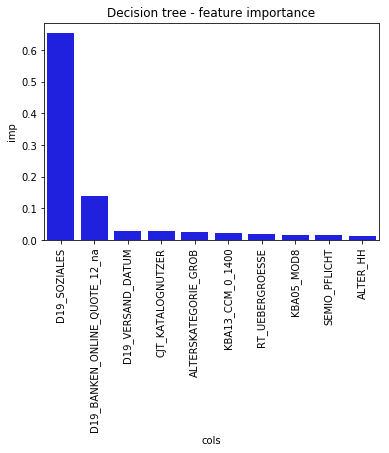

In [76]:
ax = sns.barplot(data=fi, x='cols', y='imp', color='blue')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Decision tree - feature importance')
plt.show()

Score of 0.76 is reasonable for simple model but evidence of overfitting

## Logistic regression

In [77]:
lr = LogisticRegression(class_weight='balanced')
%time lr.fit(X_train, y_train)
print_score(lr)

CPU times: user 3min 30s, sys: 0 ns, total: 3min 30s
Wall time: 3min 31s
[0.467967602012515, 0.48209126438687716, 0.87438249978609206, 0.63455019468800877]


In [78]:
line_coef(lr,X_train).head(10)

,cols,coef
366,ALTER_KIND1_na,2.284082
396,KBA13_CCM_3000_na,1.522863
368,ALTER_KIND3_na,1.269142
6,ALTER_KIND3,1.248801
11,ANZ_KINDER,1.138925
344,SOHO_KZ,1.067948
301,KONSUMZELLE,0.952270
217,KBA13_GBZ,0.948923
369,ALTER_KIND4_na,0.875807
412,VK_ZG11_na,0.871281


Comment:
- Performance of logistic regression is inferior to simple decision tree - this is unsurprising given that categorical labels are not ordered carefully and 0 entries may not be meaningful

## Random forest model

In [79]:
# Default parameters, significant overfitting

rf = RandomForestClassifier(n_jobs=-1, class_weight = 'balanced_subsample') #class_weight = 'balanced'
%time rf.fit(X_train, y_train)
print_score(rf)

CPU times: user 1.67 s, sys: 0 ns, total: 1.67 s
Wall time: 1.68 s
[0.059088786219253536, 0.10652279114564832, 0.99999248431534427, 0.53646293081464924]


Poor performance with default parameters -> Clear evidence of overfitting

### RF model tuning

In [80]:
# Train parameters on combined training and validation sets

best_rf = RandomForestClassifier(n_estimators= 1000, 
                                 min_samples_leaf=700,
                                 max_features=0.7,
                                 n_jobs=-1, 
                                 class_weight = 'balanced_subsample')

#best_rf.fit(X_train, y_train)
best_rf.fit(X_comb, y_comb)
imp = tree_feat_importance(best_rf, X_train).head(100)

In [81]:
fi = tree_feat_importance(best_rf, X_train).head(10)
fi

,cols,imp
67,D19_SOZIALES,0.515719
57,D19_KONSUMTYP_MAX,0.079704
56,D19_KONSUMTYP,0.043460
0,LNR,0.020724
95,EINGEZOGENAM_HH_JAHR,0.009874
418,randNumCol,0.007727
362,ALTERSKATEGORIE_GROB,0.007621
382,D19_VERSAND_ONLINE_QUOTE_12_na,0.007210
381,D19_TELKO_ONLINE_QUOTE_12_na,0.007153
114,HH_EINKOMMEN_SCORE,0.007094


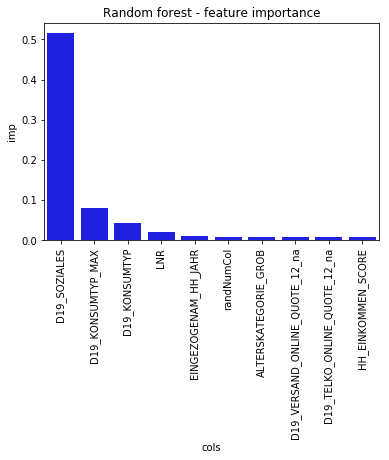

In [82]:
ax = sns.barplot(data=fi, x='cols', y='imp', color='blue')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Random forest - feature importance')
plt.show()

In [83]:
imp.reset_index(inplace=True)
cutoff = imp[imp.cols == 'randNumCol'].index[0]
top_features = list(imp['cols'].values[:cutoff])
top_features

['D19_SOZIALES',
 'D19_KONSUMTYP_MAX',
 'D19_KONSUMTYP',
 'LNR',
 'EINGEZOGENAM_HH_JAHR']

### RF with cluster info only

In [84]:
X_train_short = X_train[['cluster']]

rf = RandomForestClassifier(n_estimators= 30, n_jobs=-1, class_weight = 'balanced')

# Broad search
grid_param_rf = [{'min_samples_leaf': [100,500,1000,2000], 'max_features' :  ['sqrt',0.3,0.5,1], 'class_weight' : ['balanced', 'balanced_subsample']}]

para_search_rf = ms.GridSearchCV(estimator=rf, param_grid=grid_param_rf, cv=5, scoring = 'roc_auc', return_train_score=True)
%time para_search_rf = para_search_rf.fit(X_train_short, y_train)
tuning_results_rf = pd.DataFrame(para_search_rf.cv_results_)
tuning_results_rf.sort_values('mean_test_score', ascending=False).head()

CPU times: user 41.9 s, sys: 0 ns, total: 41.9 s
Wall time: 42.1 s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.210825,0.087620,0.013310,0.000641,balanced,sqrt,100,"{'class_weight': 'balanced', 'max_features': '...",0.538593,0.505487,0.535332,0.567904,0.605192,0.550499,0.033740,1,0.565394,0.574326,0.571009,0.562726,0.550489,0.564789,0.008231
28,0.270714,0.001888,0.012882,0.000183,balanced_subsample,1,100,"{'class_weight': 'balanced_subsample', 'max_fe...",0.546547,0.508184,0.532401,0.564782,0.600561,0.550493,0.031125,2,0.565004,0.575268,0.571836,0.562878,0.553177,0.565633,0.007674
12,0.157320,0.002113,0.012666,0.000106,balanced,1,100,"{'class_weight': 'balanced', 'max_features': 1...",0.538593,0.505820,0.530198,0.569421,0.600561,0.548916,0.032869,3,0.565394,0.575260,0.570563,0.561473,0.553177,0.565173,0.007595
8,0.156700,0.001838,0.012601,0.000081,balanced,0.5,100,"{'class_weight': 'balanced', 'max_features': 0...",0.538593,0.505820,0.526732,0.570636,0.600561,0.548466,0.033448,4,0.565394,0.575260,0.570783,0.561982,0.553177,0.565320,0.007579
20,0.273566,0.002250,0.012795,0.000115,balanced_subsample,0.3,100,"{'class_weight': 'balanced_subsample', 'max_fe...",0.538593,0.507568,0.523309,0.566560,0.605192,0.548242,0.034490,5,0.565394,0.573703,0.570836,0.562358,0.550489,0.564556,0.008081


Commnetary: Cluster result is barely better than random, suggesting clustering is not predictive of likelihood of subsrciption

### Random forest with top features only

In [85]:
# Cross validation on condensed feature set

X_train_short = X_train[top_features]

rf = RandomForestClassifier(n_estimators= 100, n_jobs=-1)#, class_weight = 'balanced')

# Search space
grid_param_rf = [{'min_samples_leaf': [100,500,1000,2000,5000], 'max_features' :  ['sqrt',0.1,0.3,0.5,0.8,1], 'class_weight' : ['balanced', 'balanced_subsample']}]
#grid_param_rf = [{'min_samples_leaf': [300,500,700], 'max_features' :  [0.2,0.3,0.4,0.5], 'class_weight' : ['balanced_subsample']}]

# Best params
#grid_param_rf = [{'min_samples_leaf': [500], 'max_features' :  [0.5], 'class_weight' : ['balanced_subsample']}]

para_search_rf = ms.GridSearchCV(estimator=rf, param_grid=grid_param_rf, cv=5, scoring = 'roc_auc', return_train_score=True)
%time para_search_rf = para_search_rf.fit(X_train_short, y_train)
tuning_results_rf = pd.DataFrame(para_search_rf.cv_results_)
tuning_results_rf.sort_values('mean_test_score', ascending=False).head()

CPU times: user 6min 1s, sys: 0 ns, total: 6min 1s
Wall time: 6min 2s


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_features,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
51,1.874007,0.012352,0.046539,0.000576,balanced_subsample,0.8,500,"{'class_weight': 'balanced_subsample', 'max_fe...",0.764729,0.778647,0.823645,0.725965,0.757902,0.770178,0.031828,1,0.817474,0.813207,0.806502,0.824999,0.816530,0.815742,0.006019
52,1.631043,0.014731,0.041866,0.000546,balanced_subsample,0.8,1000,"{'class_weight': 'balanced_subsample', 'max_fe...",0.763123,0.772751,0.824087,0.726646,0.761539,0.769629,0.031402,2,0.799188,0.796782,0.784712,0.808923,0.798700,0.797661,0.007729
16,0.989295,0.017080,0.044784,0.000144,balanced,0.5,500,"{'class_weight': 'balanced', 'max_features': 0...",0.769077,0.773286,0.822054,0.725027,0.754265,0.768742,0.031569,3,0.807280,0.807365,0.795537,0.818062,0.809113,0.807471,0.007174
15,1.281360,0.031602,0.053403,0.000768,balanced,0.5,100,"{'class_weight': 'balanced', 'max_features': 0...",0.766952,0.776748,0.811667,0.733114,0.754339,0.768564,0.026024,4,0.861629,0.857269,0.859065,0.867681,0.860219,0.861173,0.003554
22,1.229132,0.015768,0.041365,0.000383,balanced,0.8,1000,"{'class_weight': 'balanced', 'max_features': 0...",0.763936,0.777115,0.825836,0.722311,0.753374,0.768515,0.033895,5,0.797079,0.796041,0.786335,0.807343,0.798315,0.797022,0.006684


In [86]:
# Best rf condensed

best_rf_cond = RandomForestClassifier(n_estimators= 100, #1000, 
                                 min_samples_leaf=1000,
                                 max_features=0.8,
                                 n_jobs=-1, 
                                 class_weight = 'balanced_subsample')

%time best_rf_cond.fit(X_train[top_features], y_train)
print(roc_auc_score(y_train, best_rf_cond.predict_proba(X_train[top_features])[:,1]))
print(roc_auc_score(y_valid, best_rf_cond.predict_proba(X_valid[top_features])[:,1]))

CPU times: user 2.09 s, sys: 0 ns, total: 2.09 s
Wall time: 2.09 s
0.799898422631
0.761576611203


In [87]:
fi = tree_feat_importance(best_rf_cond, X_train[top_features]).head(10)
fi

,cols,imp
0,D19_SOZIALES,0.650818
1,D19_KONSUMTYP_MAX,0.226936
3,LNR,0.060849
4,EINGEZOGENAM_HH_JAHR,0.043239
2,D19_KONSUMTYP,0.018158


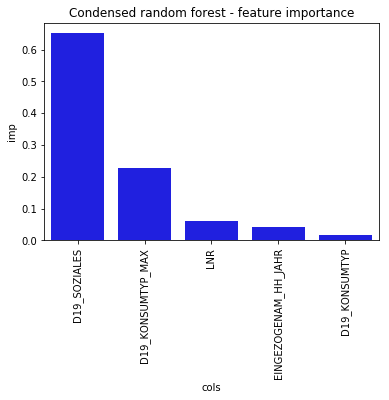

In [88]:
ax = sns.barplot(data=fi, x='cols', y='imp', color='blue')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('Condensed random forest - feature importance')
plt.show()

### Gradient boosting

Based on tuning guidance here:
    https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

In [89]:
# Best gbm

best_gbm = GradientBoostingClassifier(n_estimators=40,
                                      max_depth=8,
                                      min_samples_split=15000,
                                      max_features=0.7,
                                      subsample=0.8)

#%time best_gbm.fit(X_train, y_train)
#print_score(best_gbm)

best_gbm.fit(X_comb, y_comb)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.7, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=15000,
              min_weight_fraction_leaf=0.0, n_estimators=40,
              presort='auto', random_state=None, subsample=0.8, verbose=0,
              warm_start=False)

In [90]:
fi = tree_feat_importance(best_gbm, X_train).head(10)
fi

,cols,imp
67,D19_SOZIALES,0.296049
57,D19_KONSUMTYP_MAX,0.076654
11,ANZ_KINDER,0.066403
363,EINGEFUEGT_YEAR,0.034263
6,ALTER_KIND3,0.031326
136,KBA05_HERST3,0.023495
7,ALTER_KIND4,0.022802
56,D19_KONSUMTYP,0.017451
180,KBA05_ZUL4,0.017402
89,D19_VERSI_ONLINE_DATUM,0.016380


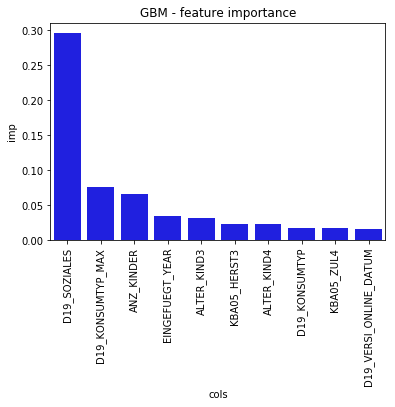

In [91]:
ax = sns.barplot(data=fi, x='cols', y='imp', color='blue')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.set_title('GBM - feature importance')
plt.show()

## Model summary

- best_rf: random forest trained on combined dataset with all features 
- best_rf_cond: random forest trained on combined dataset with features above random influence
- best_gbm: gradient boosting on combined dataset

In [92]:
# Save final models

import pickle

#filename = 'finalized_model.sav'
pickle.dump(best_rf, open('best_rf.sav', 'wb'))
pickle.dump(best_rf_cond, open('best_rf_cond.sav', 'wb'))
pickle.dump(best_gbm, open('best_gbm.sav', 'wb'))

In [93]:
# Load models

best_rf = pickle.load(open('best_rf.sav', 'rb'))
best_rf_cond = pickle.load(open('best_rf_cond.sav', 'rb'))
best_gbm = pickle.load(open('best_gbm.sav', 'rb'))

## Interpretation

- Most important feature by far is D19_SOZIALES - social transaction activity?
- D19_KONSUMTYP_MAX and RT_SCHNAEPPCHEN also important in both random forests and gradient boostign trees~

In [94]:
# Try better imputation??

In [95]:
analysis1 = mailout_train[['D19_SOZIALES','RESPONSE']].groupby(['D19_SOZIALES']).agg(['count','mean'])
analysis1.columns =['response_count', 'response_mean']

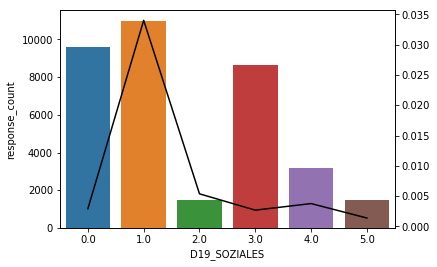

In [96]:
# Visualise reponse rate and population by cluster

ax = sns.barplot(x=analysis1.index, y=analysis1.response_count)
ax2 = ax.twinx()
ax2 = plt.plot(analysis1.response_mean, color='black')

### Further work

As next steps I would explore:

- XGBoost to improve performance
- Model stacking to combine model forecasts 

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [97]:
mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';', parse_dates = ['EINGEFUEGT_AM'])

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [98]:
mailout_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42833 entries, 0 to 42832
Columns: 366 entries, LNR to ALTERSKATEGORIE_GROB
dtypes: datetime64[ns](1), float64(267), int64(93), object(5)
memory usage: 119.6+ MB


In [99]:
# Process date column
mailout_test = process_dates(mailout_test)

df = mailout_test.copy()

In [100]:
## CLASSIFICATION PIPELINE

# Add na flags
na_dict = {}
for n,c in df.items(): 
    na_dict = fix_missing(df, c, n, na_dict)
    
%time df = preprocess_df(df)

# Clean na flags and adds random column
%time df = clean_nas(df)

#%time df = pd.DataFrame(scaler.transform(df), columns=df.columns)

CPU times: user 2.02 s, sys: 0 ns, total: 2.02 s
Wall time: 2.02 s
1 processed
2 processed
3 processed
5 processed
6 processed
8 processed
9 processed
CPU times: user 232 ms, sys: 0 ns, total: 232 ms
Wall time: 236 ms


In [101]:
## PCA PIPELINE
df_pca = preprocess_df(mailout_test)

# Prep PCA dataset
%time test_X = pd.DataFrame(scaler.transform(df_pca), columns=df_pca.columns)
test_X_pca = pd.DataFrame(pca.transform(test_X))

CPU times: user 214 ms, sys: 0 ns, total: 214 ms
Wall time: 215 ms


In [102]:
# Add cluster info to main dataset

# Add cluster info based on trained k means
df['cluster'] = kmeans.predict(test_X_pca)

In [103]:
df.shape

(42833, 420)

In [104]:
df.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA

In [105]:
y_rf = best_rf_cond.predict_proba(df[top_features])[:,1]

y_rf = best_rf.predict_proba(df)[:,1]
y_gbm = best_gbm.predict_proba(df)[:,1]

# Stacked model
y_test = 0.5*y_rf + 0.5*y_gbm

In [106]:
preds = pd.DataFrame(y_test, columns = ['RESPONSE'])
final_submission = pd.concat([mailout_test['LNR'],preds], axis=1)

In [107]:
# Output for Kaggle submission
# https://www.kaggle.com/c/udacity-arvato-identify-customers/notebooks

final_submission.to_csv("submission1.csv", index=False)

### Results

Stacked submission achieved f-score of 0.79529 with ranking of 80/193

In [108]:
final_submission.head()

,LNR,RESPONSE
0,1754,0.368503
1,1770,0.384647
2,1465,0.086127
3,1470,0.089881
4,1478,0.105062
